In [58]:
import sys
sys.path.append("../../src")

# Calibrate Cameras

In [59]:
import numpy as np
import cv2
from cv2 import aruco
from matplotlib import pyplot as plt

def calibrate_charuco(images: list, marker_length, square_length):
    '''Apply camera calibration using aruco.
    The dimensions are in cm.
    '''
    aruco_dict = aruco.Dictionary_get(aruco.DICT_4X4_50) 
    board = aruco.CharucoBoard_create(5, 7, square_length, marker_length, aruco_dict)
    arucoParams = aruco.DetectorParameters_create()

    image_id = -1
    image_ids, corners_list, id_list = [], [], []
    # Find the ArUco markers inside each image
    for image in images:
        image_id = image_id + 1

        img_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        corners, ids, _ = aruco.detectMarkers(
            img_gray, 
            aruco_dict, 
            parameters=arucoParams
        )

        if ids is None: # did not detect any corners
            continue

        resp, charuco_corners, charuco_ids = aruco.interpolateCornersCharuco(
            markerCorners=corners,
            markerIds=ids,
            image=img_gray,
            board=board
        )

        if charuco_corners is None:
            continue
        
        # If a Charuco board was found, let's collect image/corner points
        # Requiring at least 20 squares
        if resp > 20:
            # Add these corners and ids to our calibration arrays
            corners_list.append(charuco_corners)
            id_list.append(charuco_ids)
            image_ids.append(image_id)

        # print markers on image
        aruco.drawDetectedMarkers(image, corners, ids)
        aruco.drawDetectedCornersCharuco(image, charuco_corners, charuco_ids)


    # Actual calibration
    _, _, _, rvecs, tvecs = aruco.calibrateCameraCharuco(
        charucoCorners=corners_list, 
        charucoIds=id_list, 
        board=board, 
        imageSize=img_gray.shape, 
        cameraMatrix=None, 
        distCoeffs=None)

    return rvecs, tvecs, image_ids

def save_coefficients(mtx, dist, tmat, path): 
    '''Save the camera matrix and the distortion coefficients to given path/file.''' 
    cv_file = cv2.FileStorage(path, cv2.FILE_STORAGE_WRITE)
    cv_file.write('K', mtx)
    cv_file.write('D', dist)
    cv_file.write('T', tmat)
    # note you *release* you don't close() a FileStorage object
    cv_file.release()

def load_coefficients(path):
    '''Loads camera matrix and distortion coefficients.'''
    # FILE_STORAGE_READ
    cv_file = cv2.FileStorage(path, cv2.FILE_STORAGE_READ)

    # note we also have to specify the type to retrieve other wise we only get a
    # FileNode object back instead of a matrix
    camera_matrix = cv_file.getNode('K').mat()
    dist_matrix = cv_file.getNode('D').mat()
    transf_matrix = cv_file.getNode('T').mat()

    cv_file.release()
    return [camera_matrix, dist_matrix, transf_matrix]

In [60]:
def get_homogeneous(rvecs, tvecs):
    hom = np.identity(4)
    rmat, _ = cv2.Rodrigues(np.reshape(rvecs, -1))
    hom[0:3, 0:3] = rmat
    hom[0:3, 3] = np.squeeze(tvecs[0])
    return hom

In [61]:
def inverse_affine(mat):
    rot = mat[0:3, 0:3]
    trans = mat[0:3, 3]
    rot_inv = np.linalg.inv(rot)
    trans_inv = -rot_inv @ trans
    inv_mat = np.identity(4)
    inv_mat[0:3, 0:3] = rot_inv
    inv_mat[0:3, 3] = trans_inv
    return inv_mat

### Calculate & save intr. & extr. matrix

Mean Transformation Matrix:
[[ 5.07572482e-01 -5.18348797e-01 -9.53257055e-02  7.45188825e+01]
 [-6.72691202e-01  1.71152803e-01 -2.47787919e-01 -2.90996995e+02]
 [ 2.37092047e-01  1.45558957e-01 -2.78150463e-01 -1.16615772e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
Standard Deviation of Transformation Matrizes:
[[3.64213492e-01 5.73202227e-01 5.81846165e-02 1.39761774e+02]
 [2.84295562e-01 5.78376019e-01 2.03596725e-01 1.07643021e+02]
 [1.42016371e-01 1.33244966e-01 8.98503980e-01 3.31125358e+01]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]]


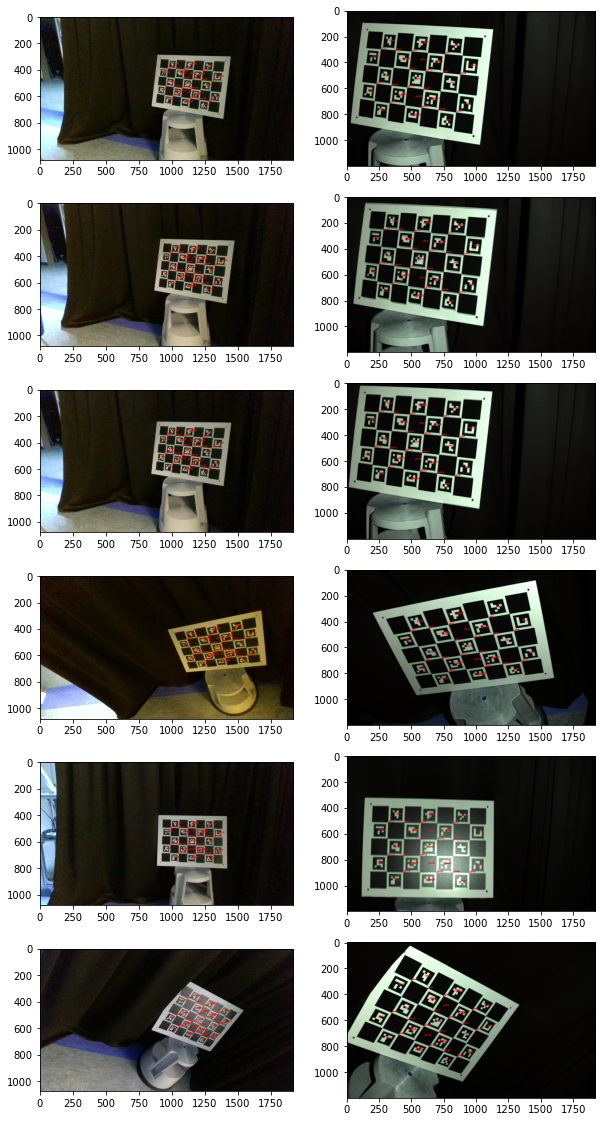

In [62]:
from matplotlib import pyplot as plt
from models.dataset.DatasetHelper import openImageDataset


# Parameters
DATASET_PATH = "../../resources/images/uncalibrated/calibration_dataset.npz"

# Dimensions in cm
MARKER_LENGTH = 5.625
SQUARE_LENGTH = 7.5

# load images
realsenseColor, _, zividColor, _ = openImageDataset(DATASET_PATH)

# Calibrate 
rvecs_rs, tvecs_rs, image_ids_rs = calibrate_charuco(
    realsenseColor,
    MARKER_LENGTH,
    SQUARE_LENGTH
)

rvecs_ziv, tvecs_ziv, image_ids_ziv = calibrate_charuco(
    zividColor,
    MARKER_LENGTH,
    SQUARE_LENGTH
)

# Calculate both homogenous transformation matrixes
Ts_rs = []
Ts_ziv = []
ids = [(i, j)  for i, x in enumerate(image_ids_rs) for j, y in enumerate(image_ids_ziv) if x == y]

for idx, (id_rs, id_ziv) in enumerate(ids):
    Ts_rs.append(get_homogeneous(rvecs_rs[id_rs], tvecs_rs[id_rs]))
    Ts_ziv.append(get_homogeneous(rvecs_ziv[id_ziv], tvecs_ziv[id_ziv]))

Ts_ziv_to_rs = []
for T_rs, T_ziv in zip(Ts_rs, Ts_ziv):
    ex = inverse_affine(T_rs) @ T_ziv
    Ts_ziv_to_rs.append(ex)

T_ziv_to_rs = np.mean(Ts_ziv_to_rs, axis=0)

print("Mean Transformation Matrix:")
print(T_ziv_to_rs)

print("Standard Deviation of Transformation Matrizes:")
print(np.std(Ts_ziv_to_rs, axis=0))

# plot images
f, axarr = plt.subplots(len(ids), 2, figsize=(10, 20))
for idx, img_id in enumerate(list(set(image_ids_rs) & set(image_ids_ziv))):
    axarr[idx][0].imshow(realsenseColor[img_id])
    axarr[idx][1].imshow(zividColor[img_id])

# Save coefficients into a file
# save_coefficients(mtx_rs, dist_rs, T_rs, '../../resources/calibrations/calibration_rs.yml')
# save_coefficients(mtx_ziv, dist_ziv, T_ziv, '../../resources/calibrations/calibration_ziv.yml')

0.075 m
4x4 aruco a 1/8 bzw 6/8 * 0.075 

# Transform Images
[https://towardsdatascience.com/how-to-transform-a-2d-image-into-a-3d-space-5fc2306e3d36](https://towardsdatascience.com/how-to-transform-a-2d-image-into-a-3d-space-5fc2306e3d36)

In [86]:
def transform(image):
    (_, _, r_z), _ = cv2.Rodrigues(T_ziv_to_rs[0:3, 0:3])
    theta_rz = np.deg2rad(r_z)

    # get the height and the width of the image
    h, w = image.shape[:2]
    # compute its diagonal
    diag = (h ** 2 + w ** 2) ** 0.5
    # compute the focal length
    f = diag
    if np.sin(theta_rz) != 0:
        f /= 2 * np.sin(theta_rz)
        
    # set the image from cartesian to projective dimension
    H_M = np.array([[1, 0, -w / 2],
                    [0, 1, -h / 2],
                    [0, 0,      1],
                    [0, 0,      1]])
    # set the image projective to carrtesian dimension
    Hp_M = np.array([[f, 0, w / 2, 0],
                     [0, f, h / 2, 0],
                     [0, 0,     1, 0]])
    """
            We will define our matrices here in next parts
                                                            """
    Identity = np.array([[1, 0, 0, 0],
                         [0, 1, 0, 0],
                         [0, 0, 1, 0],
                         [0, 0, 0, 1]])
    
    # compute the full transform matrix
    M = Identity @ T_ziv_to_rs
    M = np.dot(Hp_M, np.dot(M, H_M))
    # apply the transformation
    image = cv2.warpPerspective(image, M, (w, h))
    return image

In [87]:
rot_vector, _ = cv2.Rodrigues(T_ziv_to_rs[0:3, 0:3])
trans_vector = T_ziv_to_rs[0:3, 3]
print(rot_vector, trans_vector)

for ziv in zividColor:
    updated_image = transform(ziv)
plt.imshow(updated_image)

[[ 1.91282966]
 [-1.45918466]
 [ 0.10365333]] [  74.51888248 -290.99699463 -116.61577158]
[625771.63803999]


/tmp/ipykernel_133715/3260402358.py:21: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  Hp_M = np.array([[f, 0, w / 2, 0],


error: OpenCV(4.5.3) :-1: error: (-5:Bad argument) in function 'warpPerspective'
> Overload resolution failed:
>  - M data type = 17 is not supported
>  - Expected Ptr<cv::UMat> for argument 'M'


### Transform using o3d [http://www.open3d.org/docs/release/tutorial/geometry/transformation.html](http://www.open3d.org/docs/release/tutorial/geometry/transformation.html)

In [ ]:

dst = cv2.undistort(
    original, mtx_rs, dist, None, mtx_rs
)
cv2.imwrite('../../resources/images/calibrated/undist_rs.png', dst)